# How to create dynamic masks with DALL·E and Segment Anything

Today we're going to become fashion designers - we'll follow this flow to dynamically edit our generated images to create tailored, original content:
- **Setup:** Initialise your libraries and any location directories.
- **Generate original image:** Make an original image that we'll create dynamic masks from.
- **Generate mask:** Use Segment Anything to create a dynamic mask.
- **Create new image:** Generate a new image with the masked area inpainted with a fresh prompt.

Before getting started you'll need to follow the [instructions](https://github.com/facebookresearch/segment-anything) for using the Segment Anything (SAM) model open-sourced by Meta. As of May 2023, the key steps are:
- Install [Pytorch](https://pytorch.org/get-started/locally/) (version 1.7+).
- Download a [model checkpoint](https://github.com/facebookresearch/segment-anything#model-checkpoints) to use.
- Install the library using ```pip install git+https://github.com/facebookresearch/segment-anything.git```.
- Install dependencies using ```pip install opencv-python pycocotools matplotlib onnxruntime onnx```.

## Setup

Import libraries, set up image location folders and initate the SAM model

In [ ]:
!pip install torch torchvision torchaudio
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python pycocotools matplotlib onnxruntime onnx
!pip install requests
!pip install openai
!pip install numpy

In [2]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import numpy as np
import openai
import os
from PIL import Image
import requests
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import torch

# Set directories for generation images and edit images
base_image_dir = os.path.join('images','01_generations')
mask_dir = os.path.join('images','02_masks')
edit_image_dir = os.path.join('images','03_edits')

# Point to your downloaded SAM model
sam_model_filepath = './sam_vit_h_4b8939.pth'

# Initiate SAM model
sam = sam_model_registry["default"](checkpoint=sam_model_filepath)

## Generate original image

First we'll create an original image which we'll generate masks from

In [3]:
def process_dalle_images(response,filename,image_dir):
    # save the images
    urls = [datum["url"] for datum in response["data"]]  # extract URLs
    images = [requests.get(url).content for url in urls]  # download images
    image_names = [f"{filename}_{i + 1}.png" for i in range(len(images))]  # create names
    filepaths = [os.path.join(image_dir, name) for name in image_names]  # create filepaths
    for image, filepath in zip(images, filepaths):  # loop through the variations
        with open(filepath, "wb") as image_file:  # open the file
            image_file.write(image)  # write the image to the file
            
    return filepaths

In [9]:
dalle_prompt = '''
Full length, zoomed out photo of our premium Lederhosen-inspired jumpsuit. 
Showcase the intricate hand-stitched details and high-quality leather, while highlighting the perfect blend of Austrian heritage and modern fashion. 
This piece appeals to a sophisticated, trendsetting audience who appreciates cultural fusion and innovative design.
'''

In [10]:
# Generate your images
generation_response = openai.Image.create(
    prompt=dalle_prompt,
    n=3,
    size="1024x1024",
    response_format="url",
)

In [11]:
filepaths = process_dalle_images(generation_response,'generation',base_image_dir)

images/01_generations/generation_1.png


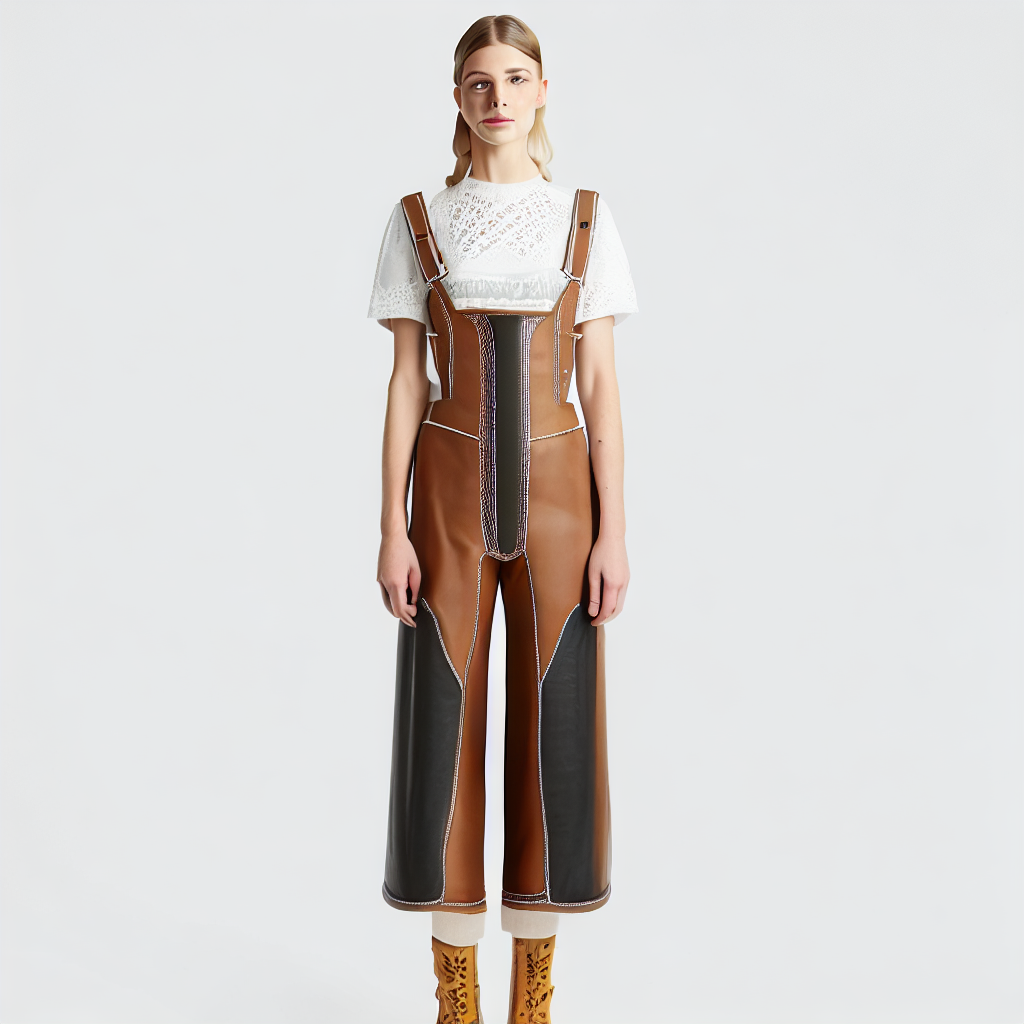

images/01_generations/generation_2.png


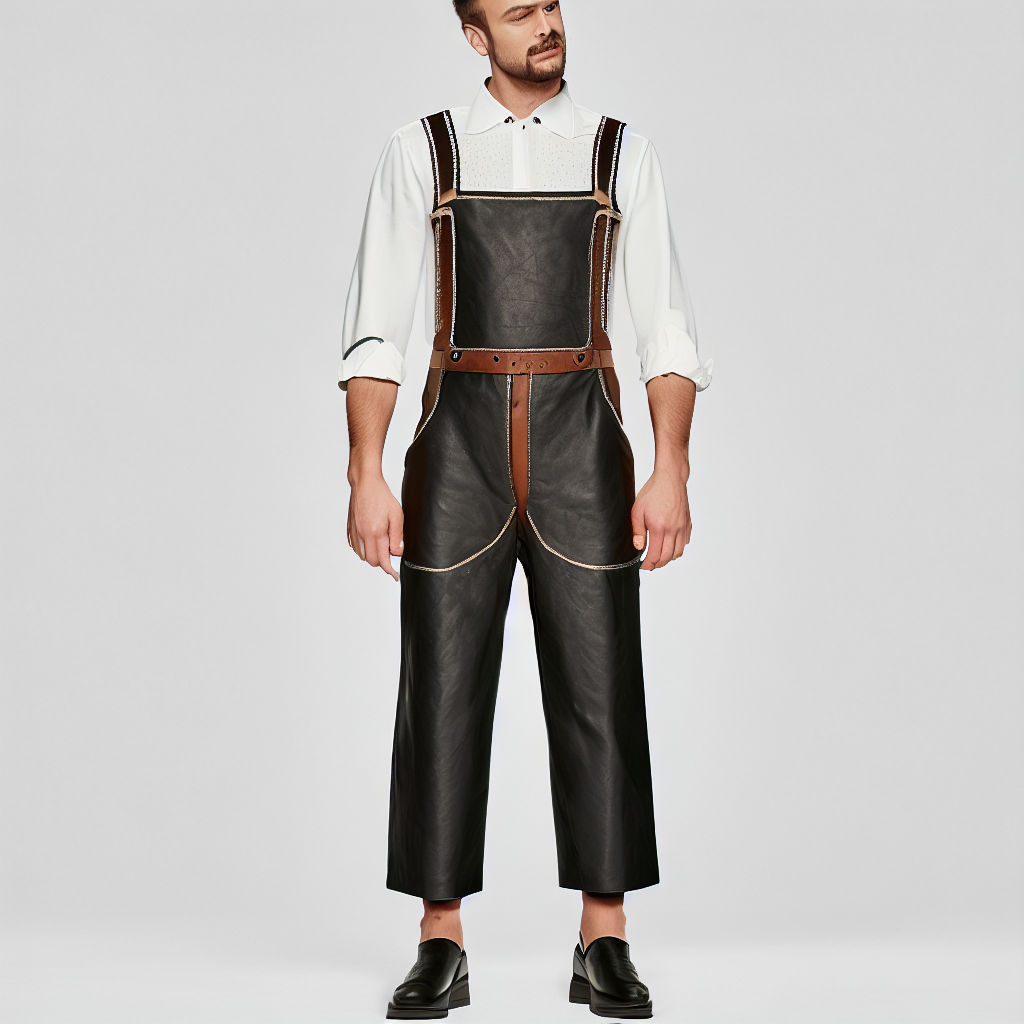

images/01_generations/generation_3.png


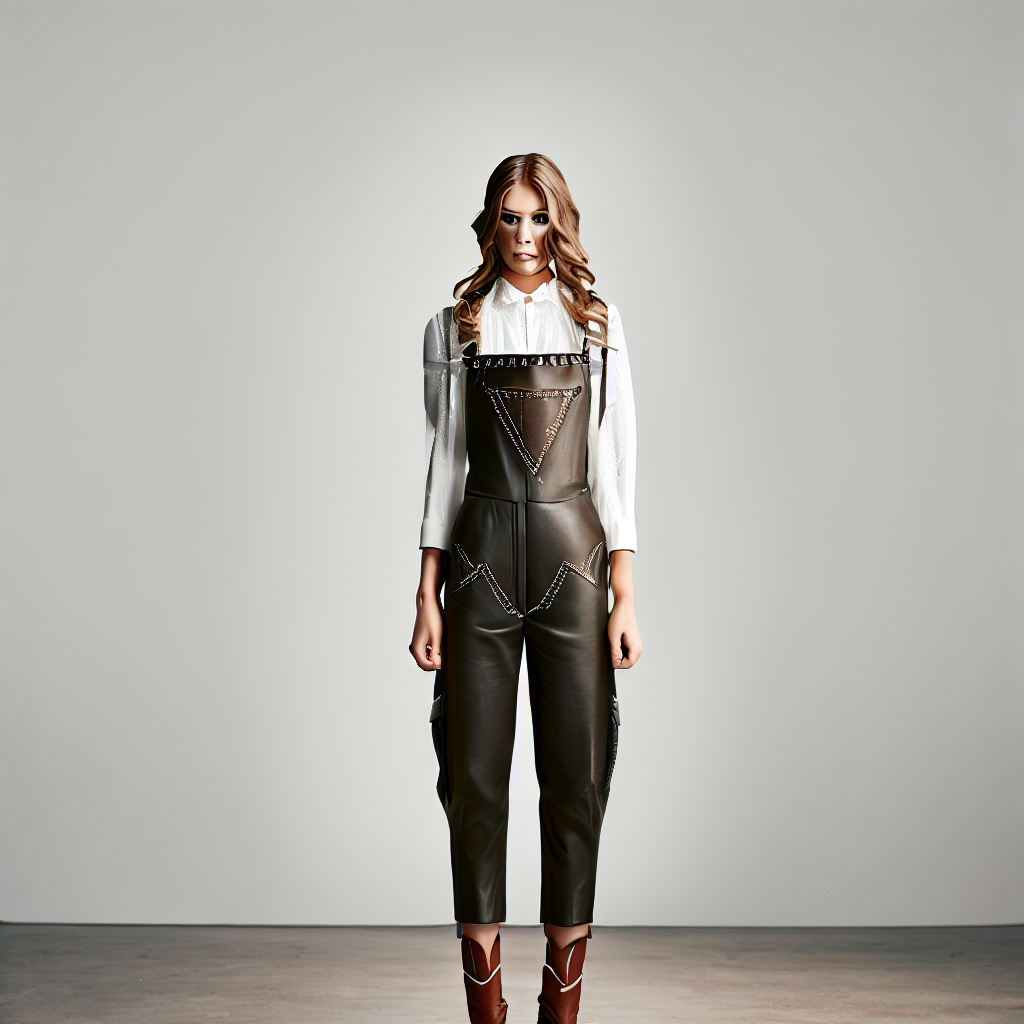

In [12]:
# print the new generations
for filepath in filepaths:
    print(filepath)
    display(Image.open(filepath))

## Generate Mask

Next we'll load up one of our images and generate masks.

For this demonstration we're picking a UX where we "click" on a point on the image to generate masks from. However, there are [example notebooks](https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb) provided by Meta which show how to generate every possible mask for an image, draw a box, and some other useful approaches.

In [13]:
# Pick one of your generated images
chosen_image = 'images/01_generations/generation_2.png'
chosen_image

'images/01_generations/generation_2.png'

In [14]:
# Function to display mask using matplotlib
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
    
# Function to display where we've "clicked"    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

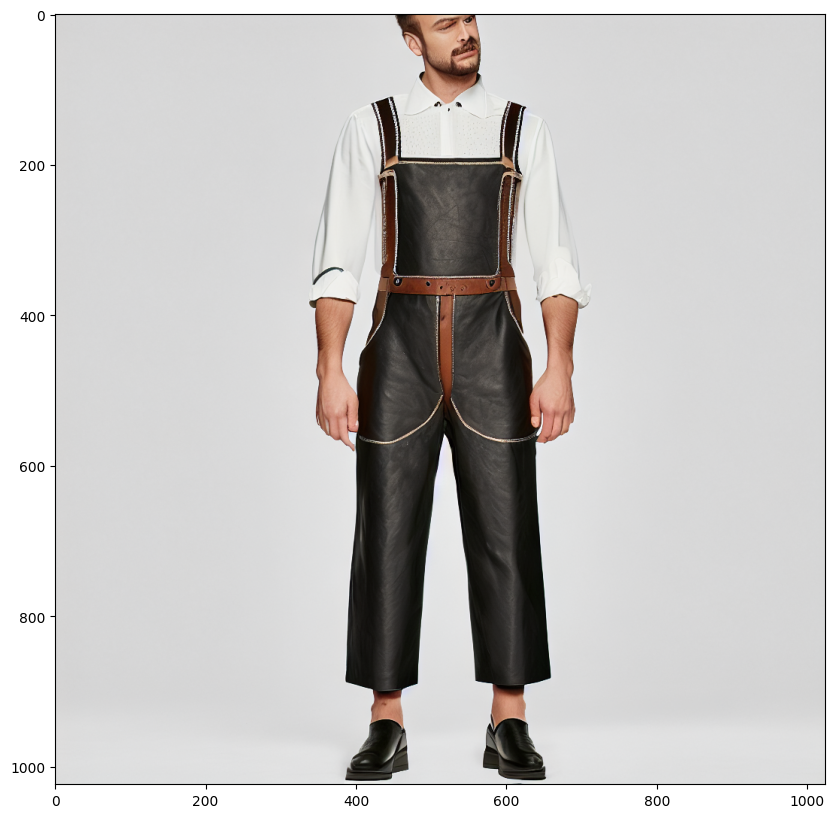

In [15]:
# Load chosen image using opencv
image = cv2.imread(chosen_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display our chosen image
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

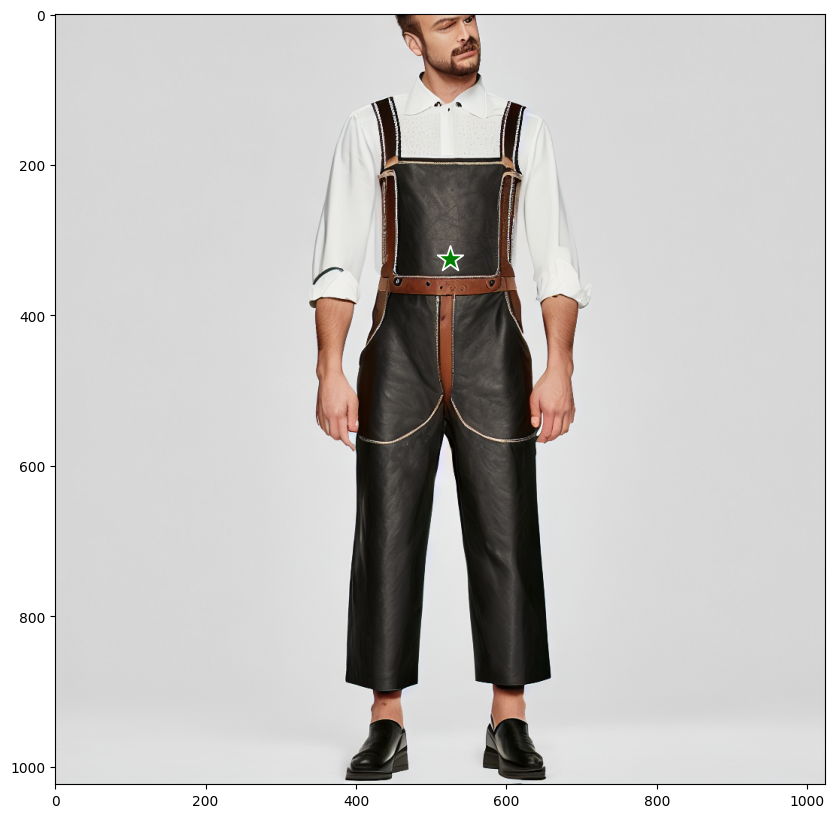

In [19]:
# Set the pixel coordinates for our "click" to assign masks
input_point = np.array([[525, 325]])
input_label = np.array([1])

# Display the point we've clicked on
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [20]:
# Initiate predictor with Segment Anything model
predictor = SamPredictor(sam)
predictor.set_image(image)

# Use the predictor to gather masks for the point we clicked
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

# Check the shape - should be three masks of the same dimensions as our image
masks.shape

(3, 1024, 1024)

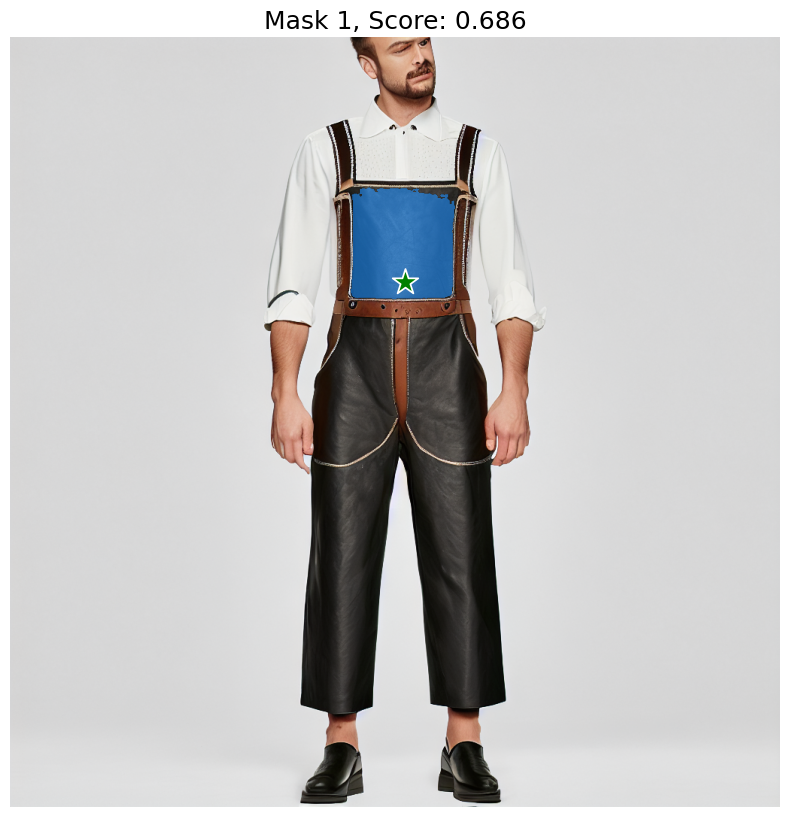

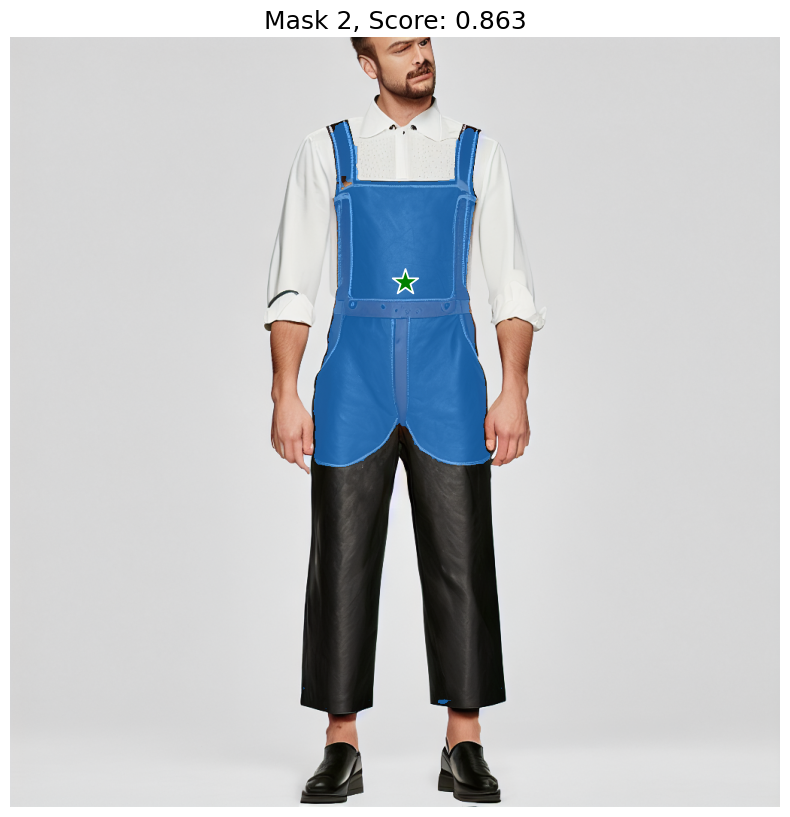

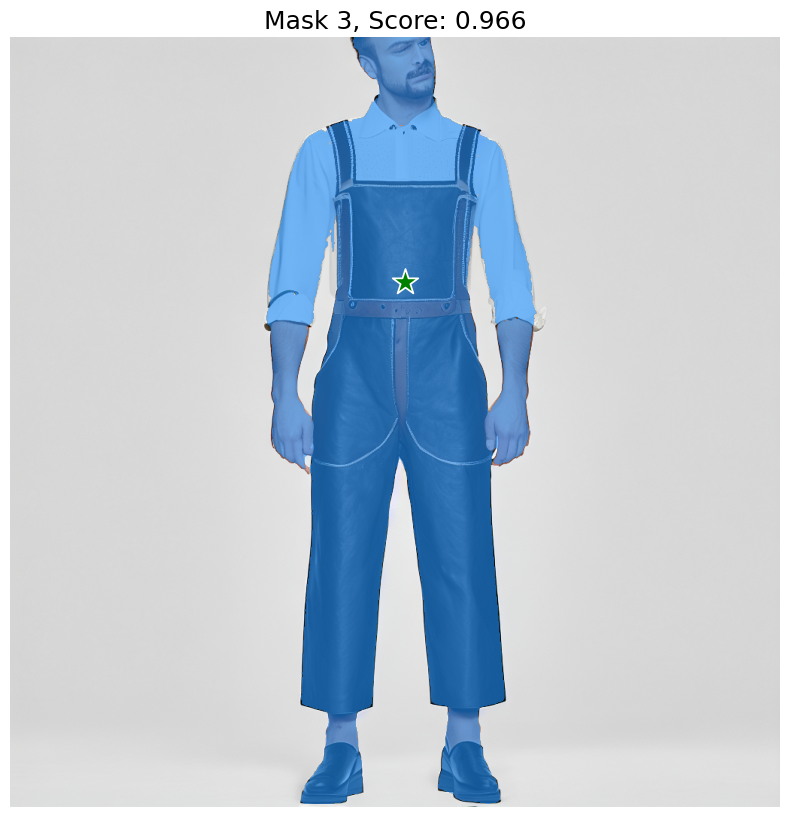

In [21]:
# Display the possible masks we can select along with their confidence
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [22]:
# Choose which mask you'd like to use
chosen_mask = masks[1]

# We'll now reverse the mask so that it is clear and everything else is white
chosen_mask = chosen_mask.astype('uint8')
chosen_mask[chosen_mask != 0] = 255
chosen_mask[chosen_mask == 0] = 1
chosen_mask[chosen_mask == 255] = 0
chosen_mask[chosen_mask == 1] = 255

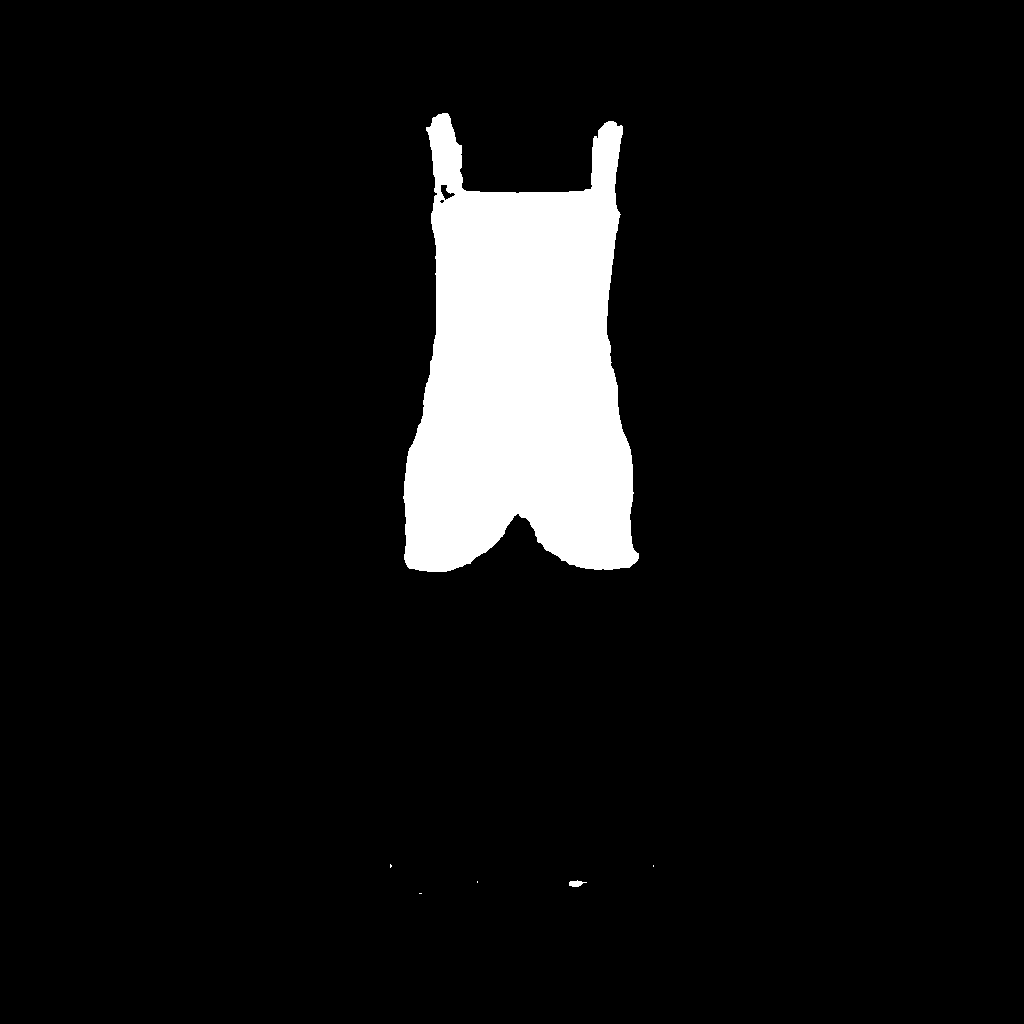

In [23]:
# create a base blank mask
width = 1024
height = 1024
mask = Image.new("RGBA", (width, height), (0, 0, 0, 1))  # create an opaque image mask

# Convert mask back to pixels to add our mask replacing the third dimension
pix = np.array(mask)
pix[:,:,3] = chosen_mask

# Convert pixels back to an RGBA image and display
new_mask = Image.fromarray(pix,'RGBA')
new_mask

In [24]:
# We'll save this mask for re-use for our edit
new_mask.save(os.path.join(mask_dir,'new_mask.png'))

## Create new image

Now we'll combine our original image with the mask and the Edit endpoint for DALLE to inpaint the transparent area according to a new prompt.

In [31]:
# edit an image

# call the OpenAI API
edit_response = openai.Image.create_edit(
    image=open(chosen_image, "rb"),  # from the generation section
    mask=open(os.path.join(mask_dir,'new_mask.png'), "rb"),  # from right above
    prompt='Brilliant leather Lederhosen with a formal look, detailed, intricate, photorealistic',  # provide a prompt to fill the space
    n=3,
    size="1024x1024",
    response_format="url",
)

edit_filepaths = process_dalle_images(edit_response,'edits',edit_image_dir)

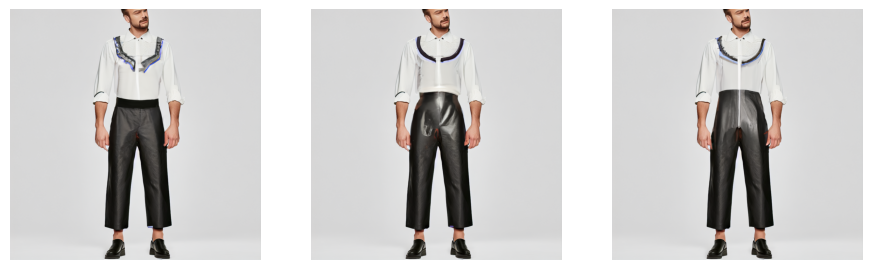

In [32]:
# Display your beautiful creations!
%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 11 ,8

# read images
img_A = mpimg.imread(edit_filepaths[0])
img_B = mpimg.imread(edit_filepaths[1])
img_C = mpimg.imread(edit_filepaths[2])

# display images
fig, ax = plt.subplots(1,3)
[a.axis('off') for a in ax]
ax[0].imshow(img_A)
ax[1].imshow(img_B)
ax[2].imshow(img_C)

Beautiful!

Now you too can easily create dynamic masks to extend your images - enjoy the APIs, and please share what you build!